In [14]:
suppressPackageStartupMessages({
    library(splatter)
    
    library(scater)
    library(scran)
    library(bluster)
    
    library(stringr)
    library(ggpubr, quietly = T)
    
    library(plyr, quietly = T)
    library(reshape2, quietly = T)
    
    library(StabEco, quietly = T)
    library(igraph, quietly = T)
    
    library(liana, quietly = T)
    library(tibble, quietly = T)
    library(reticulate, quietly = T)
#     c2c <- reticulate::import(module = "cell2cell", as="c2c")
    
    library(ggplot2, quietly = T)

})
source('../simulation_functions.r')

seed <- 888
set.seed(seed)
n.cores <- 15

env.name<-'tc2c_benchmark'
data.path<-'/data/hratch/ccc_protocols/'


return_all = TRUE
gpu_use = TRUE # when using GPU, cannot manipulate mask after in R
if (gpu_use){
    tensorly <- reticulate::import('tensorly') 
#     if return_all({
#         device<-'cuda:0'
#         tensorly$set_backend('pytorch')
#     })
}else{
    device<-NULL
}

# Functions

In [2]:
random.omit<-function(sim, md.group.label, frac, seed = 888){
    md.group<-unique(sim[[md.group.label]])
    n.md.group<-length(md.group)
    set.seed(seed)
    omit.md.group = sort(as.character(sample(md.group, size = frac*n.md.group, replace = FALSE)))
    
    return(omit.md.group)
}
                     
# get all unique elements in each tensor dimension
get.tensor.elements<-function(scores.list, score.type){
    senders<-unique(sort(unique(unname(unlist(sapply(scores.list[[score.type]], function (context.score) unique(context.score$source)))))))
    receivers<-unique(sort(unique(unname(unlist(sapply(scores.list[[score.type]], function (context.score) unique(context.score$target)))))))
    LRs<-unique(sort(unique(unname(unlist(sapply(scores.list[[score.type]], function (context.score) unique(paste0(context.score$ligand, '&', context.score$receptor))))))))
    contexts<-unique(sort(unique(names(scores.list[[score.type]]))))
    return(list(senders = senders, receivers = receivers, LRs = LRs, contexts = contexts))
}
                                                

# Simulation

Simulation parameters:

In [3]:
base_params <- newSplatParams()
n.cells<-5e3#60e3
n.cell.types<-6
n.genes<-2e3
n.lrs<-2e2

n.batches<-5 # of contexts

sim_params <- setParams(
    base_params,
    seed = seed,
    nGenes = n.genes,
    
    # batches - introduce mild ones to have context-driven changes since will treat batch as context
    batchCells = rep(n.cells/n.batches, n.batches),
    batch.rmEffect = FALSE, 
    batch.facLoc = 0.125, # higher values increase batch severity
    batch.facScale = 0.125, # higher values increase batch severity
    # cell types
    group.prob = rep(1/n.cell.types, n.cell.types), 
    de.facLoc = 0.3, # increase separation between cell types
    de.facScale = 0.6 # increase separation between cell types
)

In [4]:
# create the gold standard dataset
sim.gold<-splatSimulateGroups(sim_params, verbose = F)

# run basic qc 
sim.gold<-qc.data(sim.gold)

The cell counts are as follows:

In [5]:
df<-data.frame(colData(sim.gold))
cell.counts<-ddply(df, .(df$Batch, df$Group), nrow)
reshape2::dcast(df, Batch ~ Group)

Using Discard as value column: use value.var to override.

Aggregation function missing: defaulting to length



Batch,Group1,Group2,Group3,Group4,Group5,Group6
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
Batch1,159,147,165,176,147,176
Batch2,150,140,179,172,151,167
Batch3,173,160,162,165,149,161
Batch4,153,151,161,175,147,161
Batch5,145,161,163,170,159,171


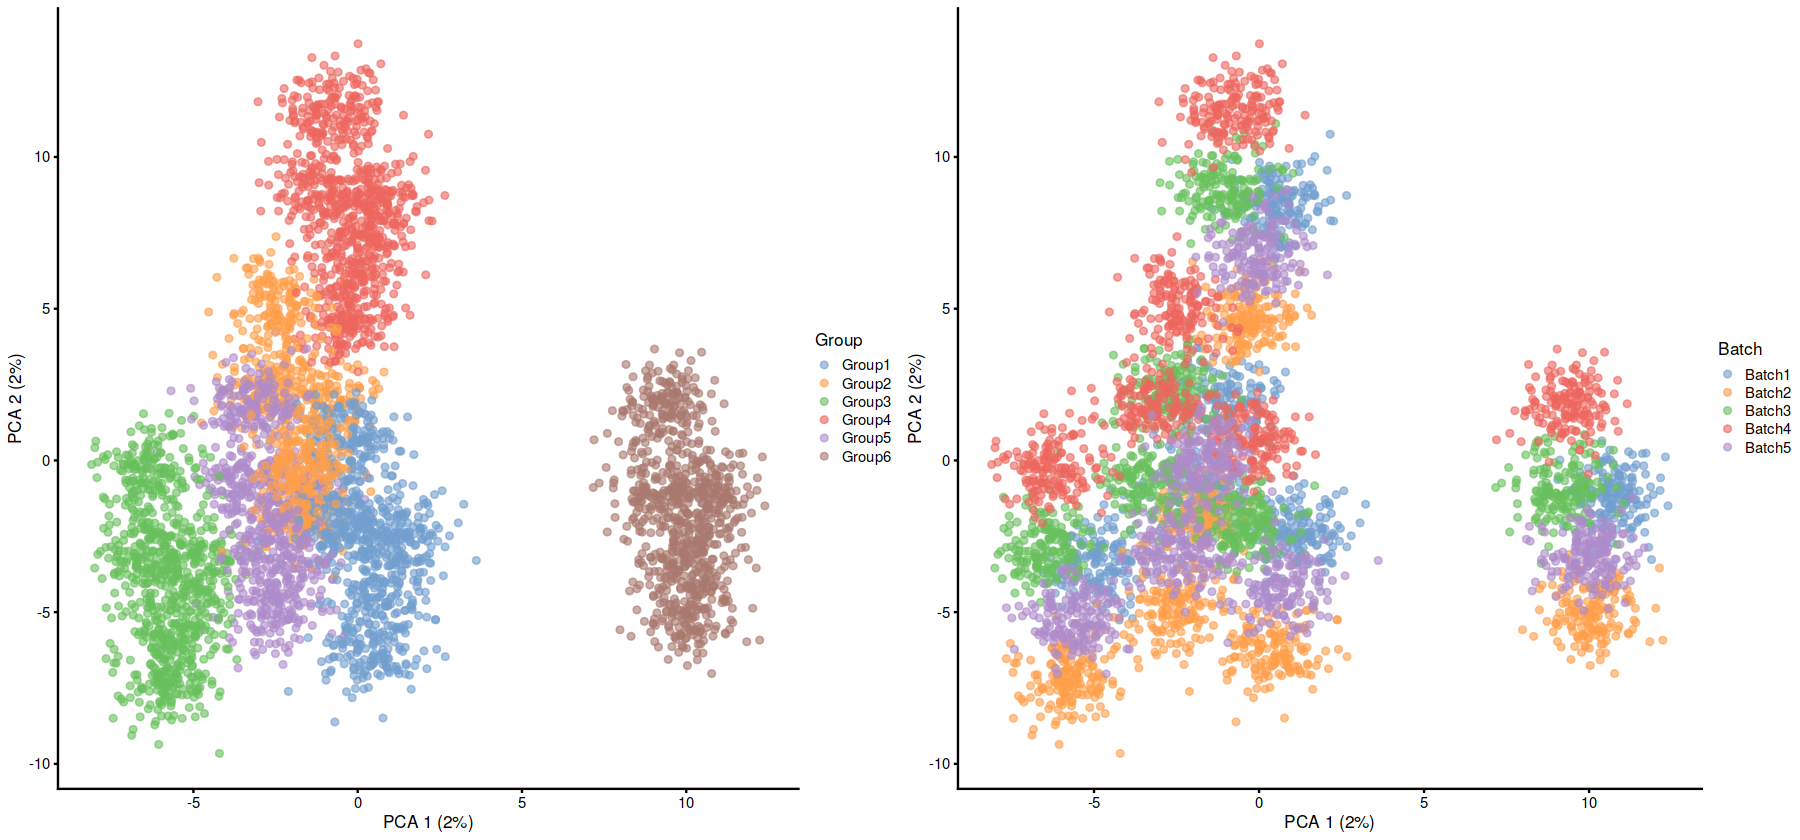

In [6]:
sim.gold.viz<-sim.gold

sim.gold.viz <- scater::logNormCounts(sim.gold.viz)
sim.gold.viz <- scran::fixedPCA(sim.gold.viz, assay.type = 'logcounts', subset.row=NULL) # default 50 PCs

h_ = 7
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

g1a<-plotPCA(sim.gold.viz, colour_by = "Group")
g1b<-plotPCA(sim.gold.viz, colour_by = "Batch")

g1<-ggpubr::ggarrange(g1a, g1b, ncol = 2)
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data.path, 'figures/', 'missing_vals_pca', ext), g1, 
                                             height = h_, width = w_)}
g1

Gold standard CCC tensor with no omitted cell types or LR pairs:

In [15]:
# generate a LR PPI on a subset of the genes
set.seed(seed)
lr.genes<-sort(as.character(sample(rownames(sim.gold), size = n.lrs, replace = FALSE)))
lr.ppi<-generate.lr.ppi(lr.genes)
interacting.lr.genes<-unique(c(lr.ppi$source_genesymbol, lr.ppi$target_genesymbol))

#####

# split by context -- needed for LR omission
sim.gold.list<-split.by.context(sim.gold) 

# log-normalize
sim.gold.list<-lapply(sim.gold.list, FUN = function(sce) {
    sce <- scater::logNormCounts(sce)
})

# calculate communication scores
scores.gold<-score.communication(sim.gold.list,
                                 check_pos = T,
                               idents_col = 'Group', 
                               assay.type = 'logcounts',
                               return_all = return_all, 
                               expr_prop = 0.05, 
                               seed = seed,
                               parallelize = T, 
                               workers = n.cores, 
                               permutation.params = list(nperms = 1), # since we don't use p-values
                               resource = 'custom',
                               external_resource = lr.ppi)

tensor.gold.elements<-list()
for (score.type in names(scores.gold)){
    tensor.gold.elements[[score.type]]<-get.tensor.elements(scores.gold, score.type)
}

# only need to separate into building/decomposing if return_all is False and a mask is introduced and need 
# to replace those values with 0s, BUT for consistency in the "runs" parameter, always separate out
# if (!return_all){ # separate out tensor building to get the masked values and re-set to true 0s
tensor.gold<-list()
for (score.type in names(scores.gold)){
    tensor.gold[[score.type]]<-liana_tensor_c2c(context_df_dict = scores.gold[[score.type]],
                                       score_col = 'score',
                                       ligand_col = 'ligand', 
                                       receptor_col = 'receptor', 
                                       lr_fill = NA, 
                                       cell_fill = NA,
                                       how = 'outer',
                                       seed = seed, 
                                       conda_env = env.name,
                                       device = NULL,
                                       build_only = T)


}

if (!return_all){
     # get the values that are masked in the gold standard, if they weren' filled in by return_all parameter
    # these are true zeros which will be used for cheking the fill in the omitted tensors that have masks
    zeros.gold<-lapply(tensor.gold, function(tensor.obj) which(tensor.obj$mask == 0, arr.ind = T))
    names(zeros.gold)<-names(tensor.gold)
}
   
if (gpu_use){
    if gpu_use({tensorly$set_backend('pytorch')})
    for (tensor.obj in tensor.gold)({
        tensor.obj$to_device('cuda')
    })
}                      

for (score.type in names(tensor.gold)){
    if (!return_all){
        # remove the masked indices so that they are treated as 0 
        # (this is like having set lr_fill and cell_fill above to 0)
        mask<-tensor.gold[[score.type]]$mask
        mask[mask == 0] = 1
        tensor.gold[[score.type]]$mask<-mask
    }
    
    # identify the rank and run the decomposition
    tensor.gold[[score.type]]<-liana::decompose_tensor(tensor = tensor.gold[[score.type]],
                                                       rank = NULL, 
                                                       tf_optimization = 'regular', 
                                                       seed = seed, 
                                                       upper_rank = 25, 
                                                       init = 'svd', 
                                                       factors_only = F, 
                                                       ) # estimate the rank by setting to NULL
    print(paste0('The rank using ', score.type, ' is ', tensor.gold[[score.type]]$rank))
}
if (gpu_use)({tensorly$set_backend('numpy')}) # need to change back to be able to manipulate masks, etc

[1] 0


Loading `tc2c_benchmark` Conda Environment

Building the tensor using score...



[1] 0


Loading `tc2c_benchmark` Conda Environment

Building the tensor using score...



Visualize:

In [32]:
natmi.factors <- liana:::format_c2c_factors(tensor.gold$natmi$factors)
sca.factors <- liana:::format_c2c_factors(tensor.gold$sca$factors)

In [49]:
factors$contexts$context

[1] Batch1 Batch2 Batch3 Batch4 Batch5
Levels: Batch1 Batch2 Batch3 Batch4 Batch5

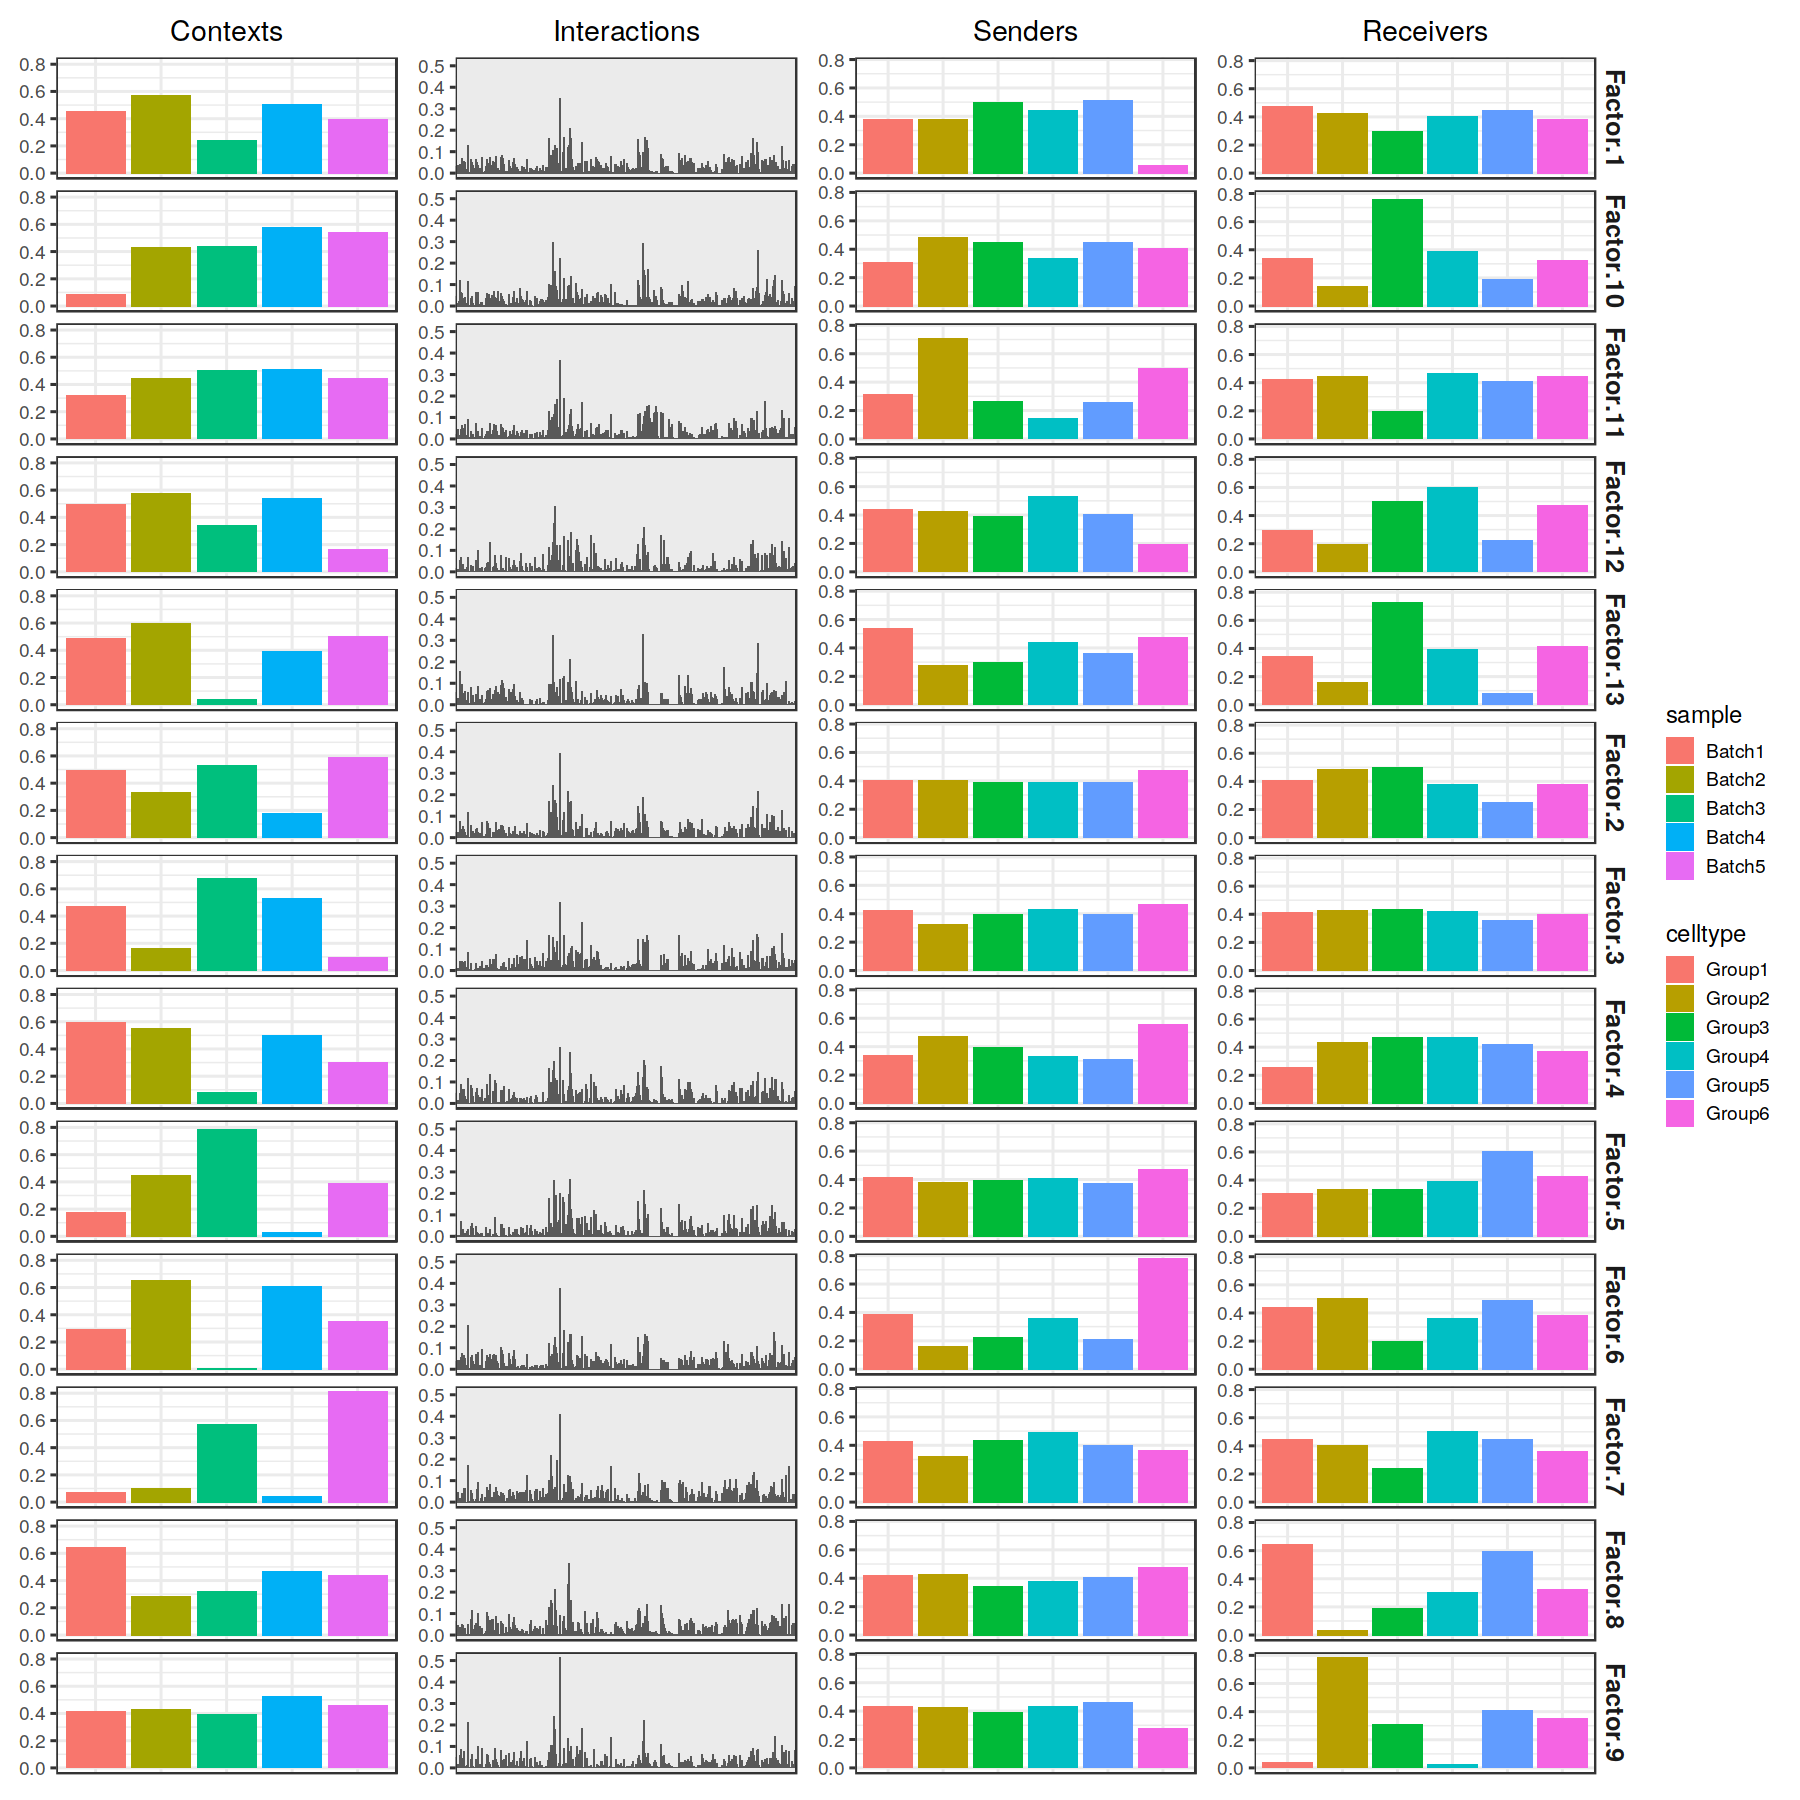

In [63]:
h_ = 15
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

sim.gold.natmi.viz<-sim.gold
sim.gold.natmi.viz@colData[['sample']]<-sim.gold.natmi.viz@colData$Batch
sim.gold.natmi.viz@metadata$tensor_res<-liana:::format_c2c_factors(tensor.gold$natmi$factors)
plot_c2c_overview(sim.gold.natmi.viz, sample_col = 'Batch', group_col = 'sample')

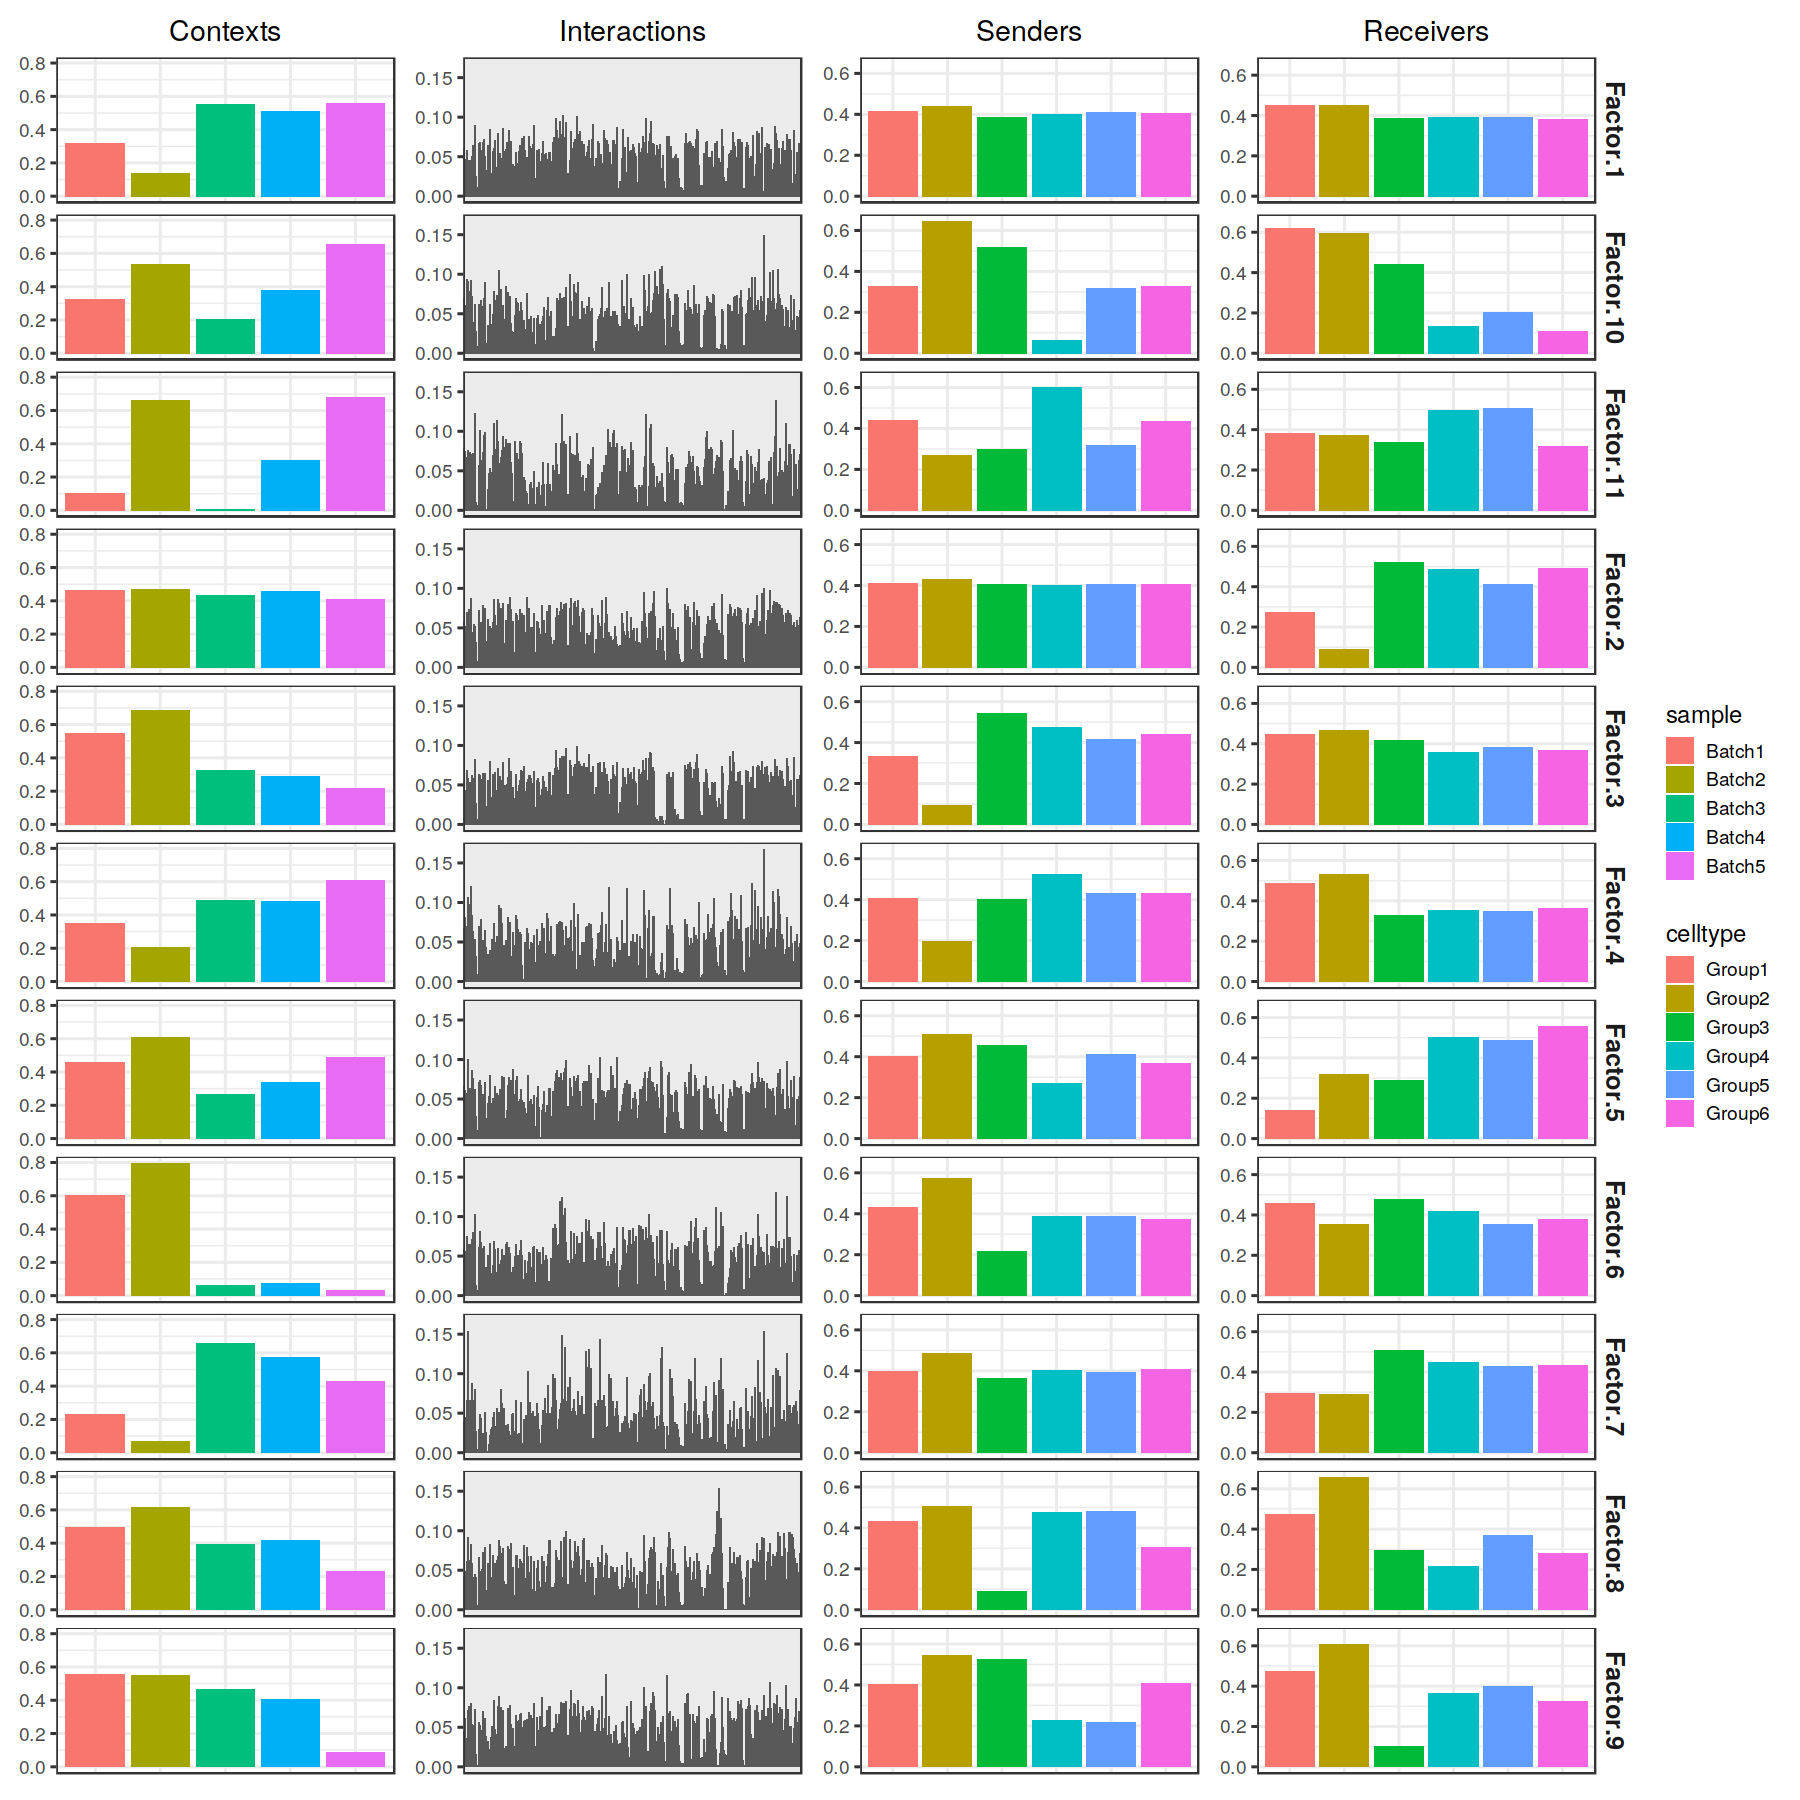

In [64]:
h_ = 15
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

sim.gold.sca.viz<-sim.gold
sim.gold.sca.viz@colData[['sample']]<-sim.gold.sca.viz@colData$Batch
sim.gold.sca.viz@metadata$tensor_res<-liana:::format_c2c_factors(tensor.gold$sca$factors)
plot_c2c_overview(sim.gold.sca.viz, sample_col = 'Batch', group_col = 'sample')

# you are here

1) change to aggregate score
2) apply all changes above to iterations below

## Set up Iterable Parameters

In [ ]:
# fraction of .* to omit
frac.contexts = seq(0.2, 0.6, 0.2) # fraction of contexts to omit cell types
frac.cts = seq(1/6, 2/3, 1/6)
frac.lrs = seq(0.1, 0.6, 0.2)

# same or different .* to omit across contexts -- true/same is more difficult problem
consistent.remove.cts = c(TRUE, FALSE) 
consistent.remove.lrs = c(TRUE, FALSE)

The fraction and actual number of cell types to be ommitted is:

In [ ]:
frac.contexts
frac.contexts*n.batches

The fraction and actual number of cell types to be ommitted is:

In [ ]:
frac.cts
frac.cts*n.cell.types

The fraction and actual number of LRs to be ommitted is:

In [ ]:
frac.lrs
frac.lrs*length(interacting.lr.genes)

In [ ]:
iter.params.list<-list()
counter<-1
for (frac.ct in frac.cts){
    for (frac.lr in frac.lrs){
        for (frac.context in frac.contexts){
            for (cr.ct in consistent.remove.cts){
                for (cr.lr in consistent.remove.lrs){
                    iter.params.list[[counter]]<-list(frac.ct = frac.ct, frac.lr = frac.lr, 
                                                      frac.context = frac.context, cr.ct = cr.ct, cr.lr = cr.lr)
                    counter<-counter + 1
                }
            }
        }
    }
}

## Iterate: NaNs/Masking

In [ ]:
print(paste0('The number of iterations is: ', length(iter.params.list)))

In [ ]:
res.df <- data.frame(matrix(ncol = 11, nrow = 0))
res.col.names<-c('iteration', 'celltype.fraction', 'lr.fraction', 'context.fraction', 'celltype.consistent', 'lr.consistent', 
                   'missing.fraction', 'corrindex.masked.natmi', 'corrindex.masked.sca',
                'corrindex.zeros.natmi', 'corrindex.zeros.sca')
colnames(res.df)<-res.col.names

seed.iter<-1
iter<-1

In [ ]:
print('Begin iteration: ')
for (iter.params in iter.params.list[1:2]){
    try({

        print(paste0('Iteration no.: ', iter))
        # select contexts, cell types, and LRs to omit-------------------------------------------------------------
        omit.contexts.ct <- random.omit(sim = sim.gold, md.group.label = 'Batch', frac = iter.params$frac.context, seed = seed.iter)
        seed.iter<-seed.iter + 1
        omit.contexts.lr <- random.omit(sim = sim.gold, md.group.label = 'Batch', frac = iter.params$frac.context, seed = seed.iter)
        seed.iter<-seed.iter + 1

        omit.cts <- list()
        if (iter.params$cr.ct){
            ocs <- random.omit(sim = sim.gold, md.group.label = 'Group', frac = iter.params$frac.ct, seed = seed.iter)
            seed.iter<-seed.iter + 1
            for (oc in omit.contexts.ct){
                omit.cts[[oc]] = ocs
            }
        }else{
            for (oc in omit.contexts.ct){
                omit.cts[[oc]] = random.omit(sim = sim.gold, md.group.label = 'Group', frac = iter.params$frac.ct, seed = seed.iter)
                seed.iter<-seed.iter + 1
            }
        }

        omit.lrs <- list()
        if (iter.params$cr.lr){
            set.seed(seed.iter)
            olrs<-sort(as.character(sample(interacting.lr.genes, size = iter.params$frac.lr*length(interacting.lr.genes), replace = FALSE)))
            seed.iter<-seed.iter + 1
            for (oc in omit.contexts.lr){
                omit.lrs[[oc]] = olrs
            }
        }else{
            for (oc in omit.contexts.lr){
                set.seed(seed.iter)
                olrs<-as.character(sample(interacting.lr.genes, size = iter.params$frac.lr*length(interacting.lr.genes), replace = FALSE))
                omit.lrs[[oc]] = olrs
                seed.iter<-seed.iter + 1
            }
        }
        # ----------------------------------------------------------------------------------------------------------
        set.seed(seed) # reset to main

        # apply the omissions
        sim.omit.list<-sim.gold.list

        for (context in names(omit.cts)){
            sce.omit <- sim.omit.list[[context]]
            cell.types.omit = omit.cts[[context]]
            barcodes.keep = rownames(colData(sce.omit)[!(colData(sce.omit)$Group %in% cell.types.omit),])
            sim.omit.list[[context]] <- sce.omit[, barcodes.keep]
        }


        for (context in names(omit.lrs)){
            sce.omit<-sim.omit.list[[context]]
            sim.omit.list[[context]]<-sce.omit[!(rownames(sce.omit) %in% omit.lrs[[context]]), ]
        }

        # get the communication scores------------------------------------------------------------------------------
        # only re-calculate scores on altered contexts to save computation time

        changed.contexts<-sort(unique(c(omit.contexts.ct, omit.contexts.lr)))
        scores.omit<-score.communication(sim.omit.list, lr.ppi, changed.contexts, n.cores = n.cores)

        scores.omit[['natmi']]<-c(scores.omit$natmi, 
                                          scores.gold$natmi[!(names(scores.gold$natmi) %in% changed.contexts)])
        scores.omit[['sca']]<-c(scores.omit$sca, 
                                          scores.gold$sca[!(names(scores.gold$sca) %in% changed.contexts)])
        scores.omit<-lapply(scores.omit, function(x) x[sort(names(x))])
        
                            
        # this will restore LR pairs that were completely removed during omitting process
        # happens bc they are not present in all contexts, so if removed in some contexts, may completely dissapear
        # making tensor dimensions different and corrindex calulation impossible
        # improve: should directly insert into tensor; right now using hacky way where adding the missing LRs
        # to any of the sample communication matrices will automatically add it to the constructed tensor
        tensor.omit.elements<-list()
        for (score.type in names(scores.omit)){
            tensor.omit.elements[[score.type]]<-get.tensor.elements(scores.omit, score.type)
        }

        for (score.type in names(scores.omit)){
            for (element.type in names(tensor.omit.elements[[score.type]])){
                elements.gold<-tensor.gold.elements[[score.type]][[element.type]]
                elements.omit<-tensor.omit.elements[[score.type]][[element.type]]
                if (length(elements.omit) < length(elements.gold)){
                    if (element.type != 'LRs'){stop('Need to account for non-LR missing elements')}
                    elements.missing<-setdiff(elements.gold, elements.omit)
                    # inserting missing LRs with a NaN score should make the tensor dimensions consistent
                    # this will add a mask for these missing lrs
                    for(em in elements.missing){
                        context.score<-scores.omit[[score.type]][[1]]
                        to.add<-context.score[1, ]
                        to.add[['score']]<-NaN
                        lr.missing<-stringr::str_split(em, pattern='&')[[1]]
                        to.add[['ligand']]<-lr.missing[[1]]
                        to.add[['receptor']]<-lr.missing[[2]]
                        scores.omit[[score.type]][[1]]<-rbind(context.score, to.add)

                    }
                }
            }
        }                    
                            
        # run tensor-c2c and get the corrindex for each score type
        frac.missing = list()
        corr.index = list(masked = list(), zeros = list())

        for (score.type in names(scores.omit)){
            suppressMessages({
                suppressWarnings({
                    # build
                    tensor<-liana_tensor_c2c(context_df_dict = scores.omit[[score.type]],
                                                       score_col = 'score',
                                                       ligand_col = 'ligand', 
                                                       receptor_col = 'receptor', 
                                                       how = 'outer',
                                                       seed = 888, 
                                                       init = 'svd', 
                                                       conda_env = env.name,
                                                        device = device,
                                                       build_only = T,
                                                       rank = tensor.gold[[score.type]]$rank)
                    # mask
                    # masking will also add masks to values that were true 0 in the gold-standard but that 
                    # would have been masked using the lr_fill/cell_fill because of the structure of the dataset (i.e., the zero.gold)
                    # here, we determine whether this case should be actually masked (because we deliberately omitted something)
                    # or whether they should not be masked (because we did not deliberately omit it, but it received a mask due to the dataset structure)
                    masked.omit<-which(tensor$mask == 0, arr.ind = T)
                    masked.overlap.idxs<-match(do.call(paste, data.frame(zeros.gold[[score.type]])), 
                                              do.call(paste, data.frame(masked.omit)))
                    if (length(masked.overlap.idxs) != dim(zeros.gold[[score.type]])[[1]]){
                        stop('The gold standard masked values should be a subset of the omitted tensor masked values')
                    }

                    masked.overlap.idx<-masked.overlap.idxs[[1]]
                    zeros.omit.idx<-c()
                    for (masked.overlap.idx in masked.overlap.idxs){
                        masked.overlap<-lapply(1:4, function(i) tensor$order_names[[i]][masked.omit[masked.overlap.idx,][[i]]])
                        masked.overlap[[2]]<-stringr::str_split(masked.overlap[[2]], pattern="\\^")[[1]]
                        masked.overlap[[3]]<-unique(c(masked.overlap[[3]], masked.overlap[[4]]))

                        masked.contexts<-unique(c(omit.contexts.ct, omit.contexts.lr))

                        masked = F
                        # if (masked.overlap[[1]] %in% omit.contexts.ct){
                        if (length(intersect(masked.overlap[[3]], omit.cts[[masked.overlap[[1]]]])) > 0){
                            masked = T
                        }

                        if (length(intersect(masked.overlap[[2]], omit.lrs[[masked.overlap[[1]]]]) > 0)){
                            masked = T
                        }

                        # still a true zero, only had NaN filled in because tensor building unaware of gold-standard
                        if (!masked){
                            zeros.omit.idx<-c(zeros.omit.idx, masked.overlap.idx)
                        }

                    }
                    # do not mask values that are still true 0s
                    zeros.omit<-masked.omit[zeros.omit.idx, ]
                    tensor$mask[zeros.omit]<-1

                    frac.missing[[score.type]]<-length(which(tensor$mask == 0))/length(tensor$mask)

                    # now run the decomposition
                    tensor<-decompose_tensor(tensor = tensor,
                                           score_col = 'score',
                                           ligand_col = 'ligand', 
                                           receptor_col = 'receptor', 
                                           seed = 888, 
                                           init = 'svd', 
                                           conda_env = env.name,
                                           factors_only = F, 
                                           inplace = F,
                                           rank = tensor.gold[[score.type]]$rank)


                    # calculate corrindex
                    corr.index$masked[[score.type]]<- (1 - (c2c$tensor$metrics$correlation_index(tensor.gold[[score.type]]$factors, 
                                                                                                   tensor$factors)))

                    # re-do setting missing values as true 0
                    tensor$mask[tensor$mask == 0] = 1 
                    tensor<-decompose_tensor(tensor = tensor,
                                           score_col = 'score',
                                           ligand_col = 'ligand', 
                                           receptor_col = 'receptor', 
                                           seed = 888, 
                                           init = 'svd', 
                                           conda_env = env.name,
                                           factors_only = F, 
                                           inplace = F,
                                           rank = tensor.gold[[score.type]]$rank)
                    corr.index$zeros[[score.type]]<- (1 - (c2c$tensor$metrics$correlation_index(tensor.gold[[score.type]]$factors, 
                                                                                                       tensor$factors)))
                    })
                })
        }
        if (length(unique(frac.missing)) != 1){stop('Unexpected difference between score type missing indices')}  
        frac.missing<-unique(frac.missing)[[1]]

        res<-c(iter, unname(unlist(iter.params)), frac.missing, corr.index$masked$natmi, corr.index$masked$sca,
              corr.index$zeros$natmi, corr.index$zeros$sca)
        names(res)<-res.col.names
        res.df<-rbind(res.df, t(as.data.frame(res)))

        write.csv(res.df, paste0(data.path, 'interim/', 'missing_vals_benchmark.csv'))
    })
    iter<-iter + 1
}